In [40]:
import calendar

import xarray as xr
from xclim import sdba
import xclim as xc
from clisops.core.subset import subset_bbox
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import numpy as np

In [28]:
hist_files = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc',
]

future_files = [
    '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc',
    '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc',   
]

In [45]:
#Alice Springs
example_lat = -23.7
example_lon = 133.88
point_selection = {'lat': example_lat, 'lon': example_lon}

#Australia
lat_min = -44.5
lat_max = -10.0
lon_min = 112.0
lon_max = 156.25

In [4]:
ds_hist = xr.open_mfdataset(hist_files)
ds_hist = subset_bbox(
    ds_hist,
    start_date='1995-01-01',
    end_date='2014-12-31',
)
ds_hist['pr'] = xc.units.convert_units_to(ds_hist['pr'], 'mm d-1')

In [11]:
ds_hist = ds_hist.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})

In [90]:
ds_future = xr.open_mfdataset(future_files)
ds_future = subset_bbox(ds_future, start_date='2045-01-01', end_date='2064-12-31')
ds_future['pr'] = xc.units.convert_units_to(ds_future['pr'], 'mm d-1')

In [91]:
ds_future = ds_future.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})

## Raw data

In [111]:
qm = sdba.EmpiricalQuantileMapping.train(
    ds_future['pr'],
    ds_hist['pr'],
    nquantiles=100,
    group="time.month",
    kind='*',
)    

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

In [112]:
qm.ds

<xarray.Dataset>
Dimensions:    (lat: 145, lon: 192, month: 12, quantiles: 100)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (lat, lon, month, quantiles) float32 dask.array<chunksize=(70, 64, 12, 100), meta=np.ndarray>
    hist_q     (lat, lon, month, quantiles) float32 dask.array<chunksize=(70, 64, 12, 100), meta=np.ndarray>
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.EmpiricalQuantil...
    adj_params:         EmpiricalQuantileMapping(group=Grouper(add_dims=[], n...

In [113]:
qm.ds = qm.ds.compute()

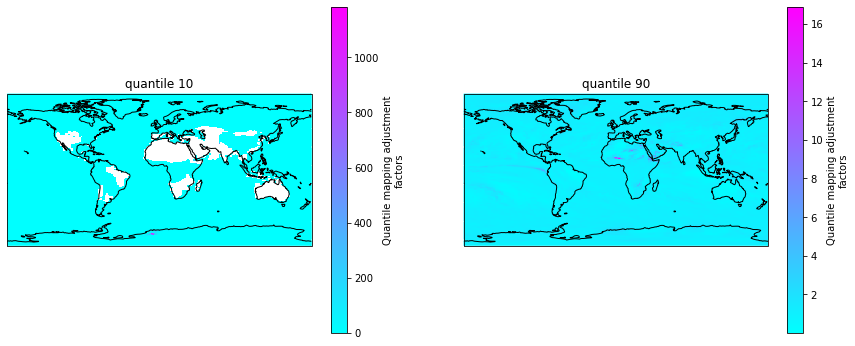

In [114]:
fig = plt.figure(figsize=[15, 6])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qm.ds['af'].isel({'quantiles': 10, 'month': 9}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
qm.ds['af'].isel({'quantiles': 90, 'month': 9}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
ax1.set_title('quantile 10')
ax2.set_title('quantile 90')
ax1.coastlines()
ax2.coastlines()
plt.show()

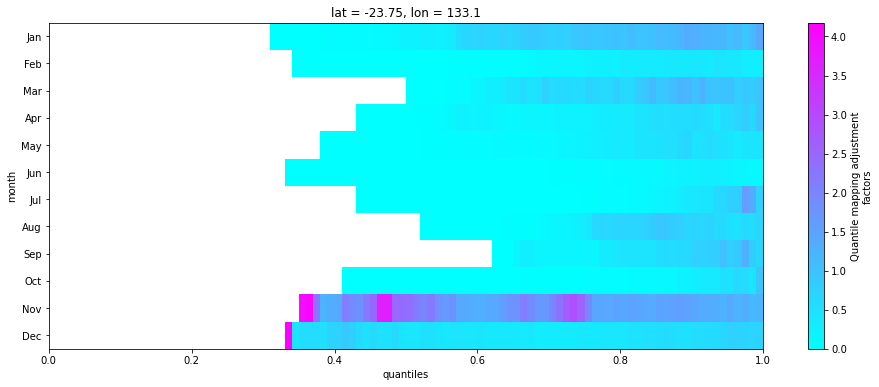

In [115]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = qm.ds['af'].sel(point_selection, method='nearest')
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [101]:
ds_hist['pr'].sel(point_selection, method='nearest').values.max()

131.02338

In [102]:
ds_hist['pr'].sel(point_selection, method='nearest').values.min()

-7.940934e-21

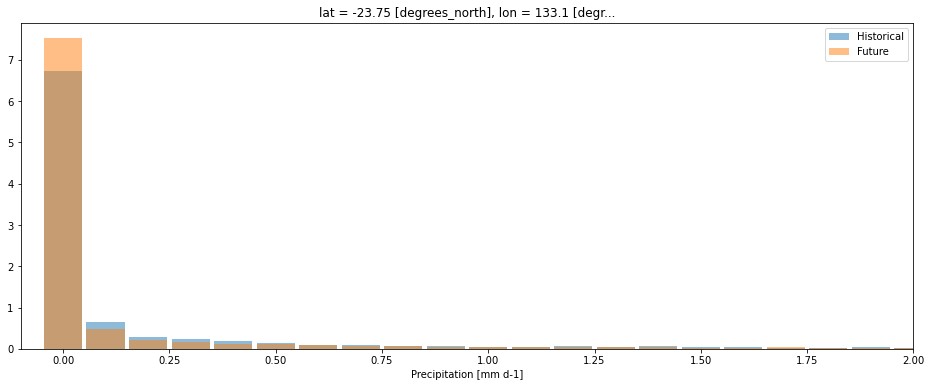

In [118]:
fig, ax = plt.subplots(figsize=[16, 6])

bins = np.arange(-0.05, 132, 0.1)

hist_plot = ds_hist['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:blue',
    label='Historical',
)

future_plot = ds_future['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:orange',
    label='Future',
)

plt.legend()
ax.set_xlim(-0.1, 2)
plt.show()

To reduce the risk of sharp change in the adjustment at the interface of the months, interp='linear' can be passed to adjust and the adjustment factors will be interpolated linearly. Ex: the factors for the 1st of May will be the average of those for april and those for may.

```python
scen = QM_mo.adjust(sim, extrapolation="constant", interp="linear")
```

In [ ]:
qm.ds = qm.ds.assign_coords({'lat': ds_future['lat'], 'lon': ds_future['lon']}) #xclim strips lat/lon attributes
qm.ds = qm.ds.transpose('quantiles', 'month', 'lat', 'lon')

## Adapt frequency


See https://xclim.readthedocs.io/en/stable/notebooks/sdba.html#First-example-:-pr-and-frequency-adaptation

```python
# 2nd try with adapt_freq
sim_ad, pth, dP0 = sdba.processing.adapt_freq(
    pr_ref, pr_sim, thresh="0.05 mm d-1", group="time"
)
QM_ad = sdba.EmpiricalQuantileMapping.train(
    pr_ref, sim_ad, nquantiles=15, kind="*", group="time"
)
```

In [88]:
future_ad, pth, dP0 = sdba.processing.adapt_freq(
    ds_hist['pr'], ds_future['pr'], thresh="0.5 mm d-1", group="time"
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

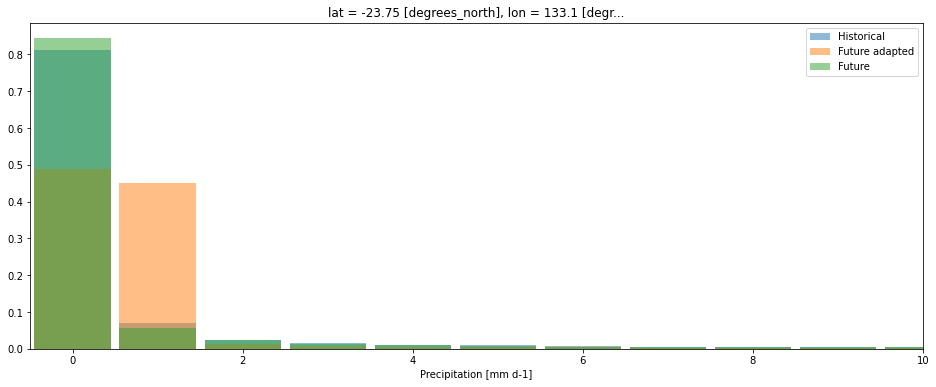

In [89]:
fig, ax = plt.subplots(figsize=[16, 6])

bins = np.arange(-0.5, 132, 1)

hist_plot = ds_hist['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:blue',
    label='Historical',
)

future_ad_plot = future_ad.sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:orange',
    label='Future adapted',
)

future_plot = ds_future['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:green',
    label='Future',
)

plt.legend()
ax.set_xlim(-0.5, 10)
plt.show()

In [75]:
qm_ad = sdba.EmpiricalQuantileMapping.train(
    future_ad,
    ds_hist['pr'],
    nquantiles=100,
    group="time.month",
    kind='*',
)   

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [76]:
qm_ad.ds

<xarray.Dataset>
Dimensions:    (lat: 145, lon: 192, month: 12, quantiles: 100)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (lat, lon, month, quantiles) float32 dask.array<chunksize=(29, 64, 12, 100), meta=np.ndarray>
    hist_q     (lat, lon, month, quantiles) float32 dask.array<chunksize=(29, 64, 12, 100), meta=np.ndarray>
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.EmpiricalQuantil...
    adj_params:         EmpiricalQuantileMapping(group=Grouper(add_dims=[], n...

In [77]:
qm_ad.ds = qm_ad.ds.compute()

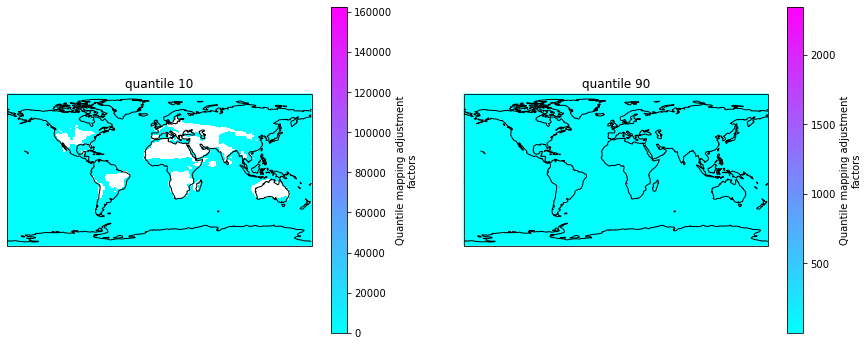

In [78]:
fig = plt.figure(figsize=[15, 6])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qm_ad.ds['af'].isel({'quantiles': 10, 'month': 5}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
qm_ad.ds['af'].isel({'quantiles': 90, 'month': 5}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
ax1.set_title('quantile 10')
ax2.set_title('quantile 90')
ax1.coastlines()
ax2.coastlines()
plt.show()

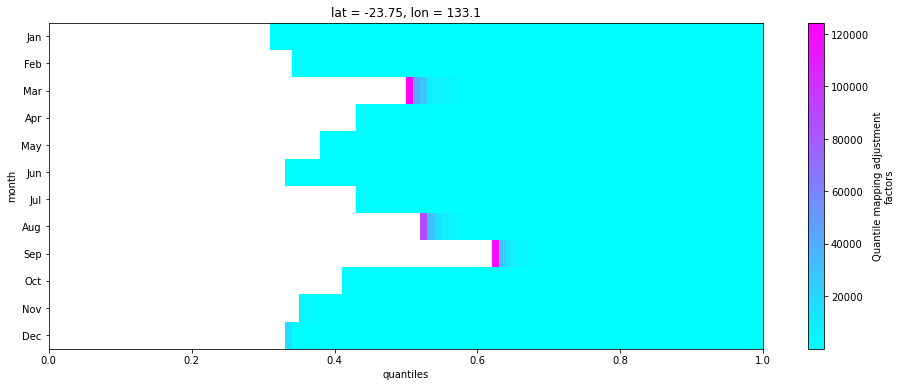

In [79]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = qm_ad.ds['af'].sel(point_selection, method='nearest')
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()